# Alphamind新手入门之八：IC衰减的计算

> 本例中计算EMA5D因子的IC衰减的情况

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from alphamind.api import *
from PyFin.api import *

from matplotlib import rc
from matplotlib import pyplot as plt

plt.style.use("seaborn-poster")
rc('font', **{'family': 'Microsoft Yahei', 'size': 10})
rc('mathtext', **{'default': 'regular'})
rc('legend', **{'frameon': False})

## 一、基础参数的设置

In [2]:
# 设置因子名称，中心化因子等
factor_name = 'EMA5D'
neutralized_styles = industry_styles
start_date = '2015-01-01'
end_date = '2020-03-01'
engine = SqlEngine(os.environ['DB_URI'])
universe_name = 'ashare'
freq = '21b'

* 通过SHIFT公式化函数，对因子的进行偏移

In [3]:
factors = {'EMA5D': LAST(factor_name),
           'EMA5D_l1': SHIFT(LAST(factor_name), 1),
           'EMA5D_l2': SHIFT(LAST(factor_name), 2),
           'EMA5D_l3': SHIFT(LAST(factor_name), 3)}

factors_names = list(factors.keys())

* 基础数据的获取

In [4]:
universe = Universe(universe_name)
dates = makeSchedule(start_date, end_date, freq, calendar='china.sse')
factors = engine.fetch_factor_range(universe, factors, dates=dates)
risk_cov, risk_factors = engine.fetch_risk_model_range(universe, dates=dates)
dx_returns = engine.fetch_dx_return_range(universe, dates=dates, horizon=map_freq(freq))
total_data = pd.merge(factors, risk_factors, on=['trade_date', 'code'])
total_data = pd.merge(total_data, dx_returns, on=['trade_date', 'code'])
total_data.dropna(inplace=True)

* 因子中性化

In [5]:
neutralized_factors = neutralize(total_data[neutralized_styles].values.astype(float),
                                 total_data[factors_names].values,
                                 groups=total_data['trade_date'].values)
total_data[factors_names] = neutralized_factors

* IC序列的计算

In [6]:
values = {}
for f in factors_names:
    ic_series = total_data.groupby('trade_date').apply(lambda x: np.corrcoef(x[f], x['dx'])[0, 1])
    values[f] = ic_series.mean()
values = pd.Series(values)

* 画出BAR图

<AxesSubplot:>

findfont: Font family ['Microsoft Yahei'] not found. Falling back to DejaVu Sans.


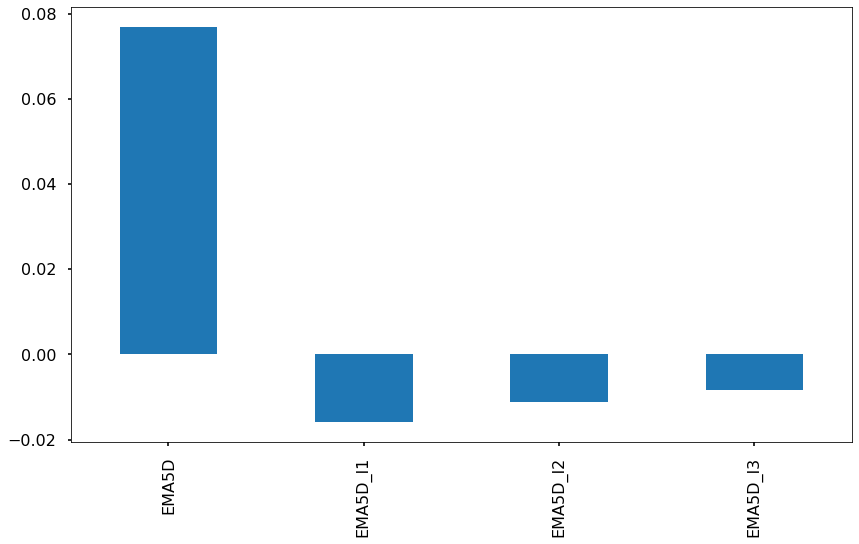

In [7]:
values.plot(kind='bar', figsize=(14, 8))